In [1]:
# TODO: delete in the main 
import sys
sys.path.insert(0, "..")

# Automatic reload
%load_ext autoreload
%autoreload 2

In [122]:
from src.extractors import LemmaExtractor, AdjectiveExtractor, DummyExtractor
from src import utils

import pandas as pd
import numpy as np
import spacy
from rich import print
from rich.text import Text

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
colorstyle = "RdBu"
sns.set_palette(colorstyle)

from tqdm import tqdm


from collections import Counter

nlp = spacy.load("en_core_web_sm")

In [3]:
sub_reviews = utils.load_data("../data/", num_samples=10000)

### Text Extractors

Before we embbed the text, we preprocess using different `text extractors`. Namely:

(1) `DummyExtractor`: This is a dummy extractor that does not do any preprocessing. It simply returns the input text as is.

(2) `LemmaExtractor`: Tokenizes the text and then uses only `lemmas` of the extracted tokens. `Lemma` is the base form of a word. For example, the lemma of `was` is `be`. Thus, the `LemmaExtractor` might be thougt of as a text normaliser which maps all tokens to the normalised space.

(3) `AdjectiveExtractor`: As the name suggests, extract tokens which were classified by spaCy as `adjectives`.

For the preprocessing and tokenization of the text, we use spaCy. SpaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python. It is designed specifically for production use and helps you build applications that process and "understand" large volumes of text. It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning.


This section introduces each of these extractors in more detail. Let's start with a simple example and see how each of these extractors output.

In [14]:
# Define the example
example = """
A) Pours with a frothy head then settles to a thin head with thin lacing. 
Transparent. Golden to bronze in color.S) Dry grains. 
Light notes of citrus - orange. Pilsner-esque.T) Very light malt sweetness - caramel. 
Moves to a dry hoppy-ness. M) Light bodied. Dry. Somewhat chalky.D) Meh. 
Just average. Not one I would suggest to a friend, but thank for the organic 
ingredients.
"""

# Preprocess the example with Spacy
example_doc = [nlp(example)]

# Define the extractors
extractors = [DummyExtractor(), LemmaExtractor(), AdjectiveExtractor()]

# Run the extractors against the example
transformed_all = []
for extractor in extractors:
    transformed_example = extractor.transform(example_doc)
    transformed_all.append(transformed_example[0])

Starting with the `DummyExtractor`, we can use it as a reference baseline for the other two extractors.

In [32]:
print(Text("DummyExtractor\n", style="bold blue"), transformed_all[0].strip())

DummyExtractor
 A) Pours with a frothy head then settles to a thin head with thin lacing. 
Transparent. Golden to bronze in color.S) Dry grains. 
Light notes of citrus - orange. Pilsner-esque.T) Very light malt sweetness - caramel. 
Moves to a dry hoppy-ness. M) Light bodied. Dry. Somewhat chalky.D) Meh. 
Just average. Not one I would suggest to a friend, but thank for the organic 
ingredients.

As the text below shows, `LemmaExtractor` has normalised the words to their base form (lemma), a couple of examples:

(1) `grains` -> `grain` (get rid of the plural form)

(2) `settles` -> `settle` (remove `s` from the he/she/it form)

(3) `bodied` -> `body` (stem form)

Apart from the lemmatisation, we can also see that how `spaCy` tokenizes the text. In particular, it treats punctuation marks as separate tokens. For example, `.` is a separate token.

In [33]:
print(Text("LemmaExtractor\n", style="bold blue"), transformed_all[1].strip())

LemmaExtractor
 a ) pour with a frothy head then settle to a thin head with thin lacing . 
 Transparent . golden to bronze in color . s ) dry grain . 
 Light note of citrus - orange . Pilsner - esque . t ) very light malt sweetness - caramel . 
 move to a dry hoppy - ness . M ) Light body . Dry . somewhat chalky . D ) Meh . 
 just average . not one I would suggest to a friend , but thank for the organic 
 ingredient .

Finally, looking at the `AdjectiveExtractor`, we can see that it stips the text to only adjectives, thereby potentially losing some useful information. On the other hand,
for the purposes of our analysis, this might be in fact useful as we only want our embeddings be based on the descriptive words related to beer and avoid the noise.

In [34]:
print(Text("AdjectiveExtractor\n", style="bold blue"), transformed_all[2].strip())

AdjectiveExtractor
 frothy thin thin Golden Dry orange esque light dry chalky average organic

Now, let's run the extractors against the selected subsample and then investigate the results in more detail. We start by preprocessing the text.

*NB:* takes around **4 minutes** to run.

In [43]:
docs = [nlp(text) for text in tqdm(sub_reviews.review.text.tolist())]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [04:01<00:00, 41.46it/s]


Now, we will run the extractors against the subsample and save the results.

In [149]:
# We map the list of docs to the list of preprocessed strings
prep_text = []
for extractor in extractors:
    prep_text_ext = extractor.transform(docs)
    prep_text.append(prep_text_ext)

Now, let's first look at the global token frequency distribution for each extractor.

In [150]:
# TODO: move this to utils?
def get_word_frequency(text_list):
    """Calculate word frequency given a list of text documents"""
    # Combine all the text documents into one large string
    combined_text = ' '.join(text_list)

    # Tokenize the text
    tokens = combined_text.split()

    # Calculate word frequency using Counter
    word_frequency = Counter(tokens)

    # Return Sorted word frequency as Pandas DataFrame
    return pd.DataFrame(word_frequency.most_common(), columns=['word', 'frequency'])

TODO: add description of what is going on

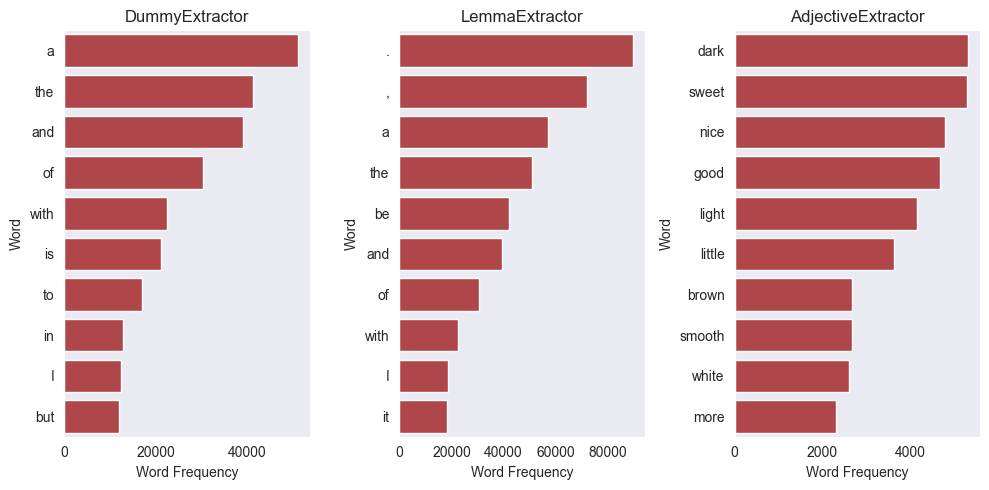

In [151]:
# Obtain the word frequency for each extractor
frequencies = [get_word_frequency(text) for text in prep_text]

# Using seaborn plot the word frequency for each extractor
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for ax, freq, extractor in zip(axes, frequencies, extractors):
    sns.barplot(x='frequency', y='word', data=freq.head(10), ax=ax)
    ax.set_title(extractor.name)
    ax.set_xlabel('Word Frequency')
    ax.set_ylabel('Word')

plt.tight_layout()

Let's now recall our hypothesis under which we assume that `words` associated with particular `beer brand` are very specific to the given beer brand. Therefore, if we zoom out and look at words associated with particular beer style, we should see greater variety of words, as such less specifity. Let's see if this is the case by using a simple approach. 


In our first experiment, we will select all reviews associated with particular beer brand. Then, we will randomly split the reviews into two disjunt sets, i.e., there will be no overlap in terms of the reviews. We then extract the adjectives and their frequencies for each of the two sets. Finally, we compare the two sets and see how many adjectives are shared between the two sets using `Jaccard Similarity`.

In our second experiment, we will follow the exact same procedure, however this time, we will sample the reviews from a subroup of beers associate with particular style.

In [152]:
# TODO: move this to utils?
def get_jaccard_similarity(df1, df2, weighted=False):
    """Calculate the weighted jaccard distance between two dataframes

    Args:
        df1 (pd.DataFrame): First dataframe with columns word and frequency
        df2 (pd.DataFrame): Second dataframe with columns word and frequency

    Returns:
        float: Weighted jaccard distance 
    """

    if weighted:
        # Merge the two dataframes on the word column
        merged = df1.merge(df2, on='word')

        # Calculate the weighted jaccard distance
        jaccard_similarity = (merged.frequency_x * merged.frequency_y).sum() / (merged.frequency_x.sum() + merged.frequency_y.sum())

    else:
        # Convert the word column to a set for each dataframe
        set1 = set(df1['word'])
        set2 = set(df2['word'])
        
        # Calculate Jaccard similarity
        jaccard_similarity = len(set1.intersection(set2)) / len(set1.union(set2))

    return jaccard_similarity

In [153]:
# Add the extracted adjectives to sub_reviews
sub_reviews['adjectives'] = prep_text[2]

In [180]:
# Get the distribution of beer styles in our dataset
styles_dist = sub_reviews.beer["style"].value_counts()*100/len(sub_reviews)

# Get the reviews associate with the most popular beer style
mostpop_style_reviews = sub_reviews[sub_reviews.beer["style"] == styles_dist.index[0]]

# Obtain unique beer brands for the most popular beer style
beer_brands = mostpop_style_reviews.beer["name"].unique()

# For each beer brand calculate the jaccard similarity between two randomly selected groups of reviews
beers_scores = []
for beer_brand in tqdm(beer_brands):
    # Get the reviews for the current beer brand
    beer_reviews = mostpop_style_reviews[mostpop_style_reviews.beer["name"] == beer_brand]

    # Only consider beer brands with more than X reviews
    if len(beer_reviews) < 160:
        continue

    # Split these reviews into two disjucnt groups randomly
    group1 = beer_reviews.sample(frac=0.5)
    group2 = beer_reviews.drop(group1.index)

    # Get the word frequency for each group
    group1_freq = get_word_frequency(group1.adjectives.tolist())
    group2_freq = get_word_frequency(group2.adjectives.tolist())

    # Calculate the jaccard similarity between the two groups
    jaccard_similarity = get_jaccard_similarity(group1_freq, group2_freq, weighted=False)

    # Append the jaccard similarity to the list of scores
    beers_scores.append(jaccard_similarity)

# Print the 95 % confidence interval for the jaccard similarity scores
print(f"Beer scores: {np.mean(beers_scores):.3f} +/- {1.96*np.std(beers_scores)/np.sqrt(len(beers_scores)):.3f}")

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 356.39it/s]


Beer scores: 0.389 +/- 0.012

In [181]:
# Now, for each pair of beer brand calculate the jaccard similarity
scores = []
for i in tqdm(range(len(beer_brands))):
    for j in range(i+1, len(beer_brands)):
        # Get the reviews for the current beer brand
        beer_reviews1 = mostpop_style_reviews[mostpop_style_reviews.beer["name"] == beer_brands[i]]
        beer_reviews2 = mostpop_style_reviews[mostpop_style_reviews.beer["name"] == beer_brands[j]]

        # Only consider beer brands with more than X reviews
        if len(beer_reviews1) < 80 or len(beer_reviews2) < 80:
            continue

        # Get the word frequency for each group
        group1_freq = get_word_frequency(beer_reviews1.adjectives.tolist())
        group2_freq = get_word_frequency(beer_reviews2.adjectives.tolist())

        # Calculate the jaccard similarity between the two groups
        jaccard_similarity = get_jaccard_similarity(group1_freq, group2_freq, weighted=False)

        # Append the jaccard similarity to the list of scores
        scores.append(jaccard_similarity)

# Print the 95 % confidence interval for the jaccard similarity scores
print(f"Beer scores: {np.mean(scores):.3f} +/- {1.96*np.std(scores)/np.sqrt(len(scores)):.3f}")

100%|██████████| 19/19 [00:00<00:00, 47.52it/s]


Beer scores: 0.391 +/- 0.016

In [182]:
scores

[0.38118466898954706, 0.38085539714867617, 0.41184298070525616]